In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sys
sys.path.append('../..')
from model import FinData
from model import train_valid_test_split
from model import CatboostFinModel
import catboost

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas as pd

In [90]:
import pandas as pd

# Загрузим два датафрейма
df1 = pd.read_csv("Gazprom.csv", parse_dates=["utc"])
df2 = pd.read_csv("Gazprom_short.csv", parse_dates=["utc"])

# Переименуем predicted_proba, чтобы они отличались
df1 = df1.rename(columns={"predicted_proba": "predicted_proba_model1"})
df2 = df2.rename(columns={"predicted_proba": "predicted_proba_model2"})

# Объединение по utc
merged = pd.merge(df1[['utc', 'open', 'close', 'predicted_proba_model1']],
                  df2[['utc', 'predicted_proba_model2']],
                  on='utc')

# Добавим колонку close_{t+1}
merged['close_t+1'] = merged['close'].shift(-1)

# Комиссия в две стороны (покупка + продажа)
commission = 0

# Условия для таргета
merged['target'] = 0
merged.loc[(merged['close_t+1'] / merged['close']) > (1 + commission), 'target'] = 1
merged.loc[(merged['close'] / merged['close_t+1']) > (1 + commission), 'target'] = -1

# Удалим последнюю строку с NaN в close_t+1
merged = merged.dropna(subset=['close_t+1'])

# Готово! Сохраняем или смотрим
print(merged.head())


                  utc    open   close  predicted_proba_model1  \
0 2024-03-01 07:00:00  161.81  162.04                0.139189   
1 2024-03-01 07:01:00  162.02  162.04                0.139163   
2 2024-03-01 07:02:00  162.04  162.47                0.137531   
3 2024-03-01 07:03:00  162.48  162.61                0.132503   
4 2024-03-01 07:04:00  162.62  162.71                0.134722   

   predicted_proba_model2  close_t+1  target  
0                0.278873     162.04       0  
1                0.161170     162.47       1  
2                0.219764     162.61       1  
3                0.184340     162.71       1  
4                0.219141     162.60      -1  


In [127]:
from catboost import CatBoostClassifier
import numpy as np

feats = ['predicted_proba_model1', 'predicted_proba_model2']

start_time = dt.datetime(2024, 4, 1)
end_time = dt.datetime(2024, 5, 1)

target = 'target'
    
curr_time = start_time

all_results = []

while curr_time < end_time:        
    train_df = merged[(merged.utc >= curr_time - dt.timedelta(days=30)) & (merged.utc <= curr_time - dt.timedelta(days=5))]
    val_df = merged[(merged.utc > curr_time - dt.timedelta(days=5)) & (merged.utc <= curr_time)]
    test_df = merged[(merged.utc > curr_time) & (merged.utc <= curr_time + dt.timedelta(days=5))]

    train_sd, val_sd, test_sd = train_df["utc"].iloc[0], val_df["utc"].iloc[0], test_df["utc"].iloc[0]
    train_ed, val_ed, test_ed = train_df["utc"].iloc[-1], val_df["utc"].iloc[-1], test_df["utc"].iloc[-1]
    print(f"Начало тренировочного периода: {train_sd}. Конец тренировочного периода: {train_ed} \n \
                Начало валидационного периода: {val_sd}. Конец валидационного периода: {val_ed} \n \
                Начало тестового периода: {test_sd}. Конец тестового периода: {test_ed} \n ")
    
    X_train, y_train = train_df[feats], train_df[target]
    X_val, y_val = val_df[feats], val_df[target]
    X_test, y_test = test_df[feats], test_df[target]

    model = CatBoostClassifier(
        iterations=10000,
        learning_rate=0.01,
        early_stopping_rounds=500,
        depth=5,
        loss_function='MultiClass',
        verbose=0,
        random_seed=42,
        class_weights=[0.03, 1.0, 0.03]  # Повышаем важность классов -1 и 1
    )


    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    proba = model.predict_proba(X_test)
    pred_class = np.argmax(proba, axis=1)
    pred_class = [model.classes_[i] for i in pred_class]

    temp_df = pd.DataFrame({
        'utc': test_df['utc'].values,
        'open': test_df['open'].values,
        'close': test_df['close'].values,
        'true_target': y_test.values,
        'predicted_class' : pred_class
    })
    temp_df = pd.concat([temp_df], axis=1)

    all_results.append(temp_df)

    curr_time += dt.timedelta(days=5)

final_df = pd.concat(all_results).reset_index(drop=True)

Начало тренировочного периода: 2024-03-02 07:01:00. Конец тренировочного периода: 2024-03-26 20:49:00 
                 Начало валидационного периода: 2024-03-27 07:00:00. Конец валидационного периода: 2024-03-31 15:59:00 
                 Начало тестового периода: 2024-04-01 07:00:00. Конец тестового периода: 2024-04-05 20:49:00 
 
Начало тренировочного периода: 2024-03-07 07:00:00. Конец тренировочного периода: 2024-03-31 15:59:00 
                 Начало валидационного периода: 2024-04-01 07:00:00. Конец валидационного периода: 2024-04-05 20:49:00 
                 Начало тестового периода: 2024-04-06 07:01:00. Конец тестового периода: 2024-04-10 20:49:00 
 
Начало тренировочного периода: 2024-03-12 07:00:00. Конец тренировочного периода: 2024-04-05 20:49:00 
                 Начало валидационного периода: 2024-04-06 07:01:00. Конец валидационного периода: 2024-04-10 20:49:00 
                 Начало тестового периода: 2024-04-11 07:00:00. Конец тестового периода: 2024-04-15 20:49:0

In [116]:
model.best_score_

{'learn': {'MultiClass': 0.3789076219938996},
 'validation': {'MultiClass': 0.3776897275270544}}

In [117]:
print(train_df['target'].value_counts())

target
 1    7755
-1    7685
 0    4008
Name: count, dtype: int64


In [118]:
final_df

,utc,open,close,true_target,predicted_class
0,2024-04-01 07:00:00,157.69,157.80,-1,0
1,2024-04-01 07:01:00,157.79,157.71,-1,0
2,2024-04-01 07:02:00,157.70,157.67,1,0
3,2024-04-01 07:03:00,157.67,157.72,1,0
4,2024-04-01 07:04:00,157.72,157.88,1,0
...,...,...,...,...,...
24021,2024-04-30 20:45:00,163.24,163.25,1,0
24022,2024-04-30 20:46:00,163.25,163.26,-1,0
24023,2024-04-30 20:47:00,163.25,163.24,1,0
24024,2024-04-30 20:48:00,163.25,163.25,-1,0


In [119]:
final_df[final_df.true_target == final_df.predicted_class]

,utc,open,close,true_target,predicted_class
8,2024-04-01 07:08:00,158.05,158.10,0,0
12,2024-04-01 07:12:00,158.08,158.18,0,0
37,2024-04-01 07:37:00,158.14,158.08,0,0
39,2024-04-01 07:39:00,158.08,158.05,0,0
57,2024-04-01 07:57:00,158.04,158.01,0,0
...,...,...,...,...,...
24013,2024-04-30 20:37:00,163.31,163.30,0,0
24014,2024-04-30 20:38:00,163.29,163.30,0,0
24017,2024-04-30 20:41:00,163.26,163.26,0,0
24018,2024-04-30 20:42:00,163.26,163.26,0,0


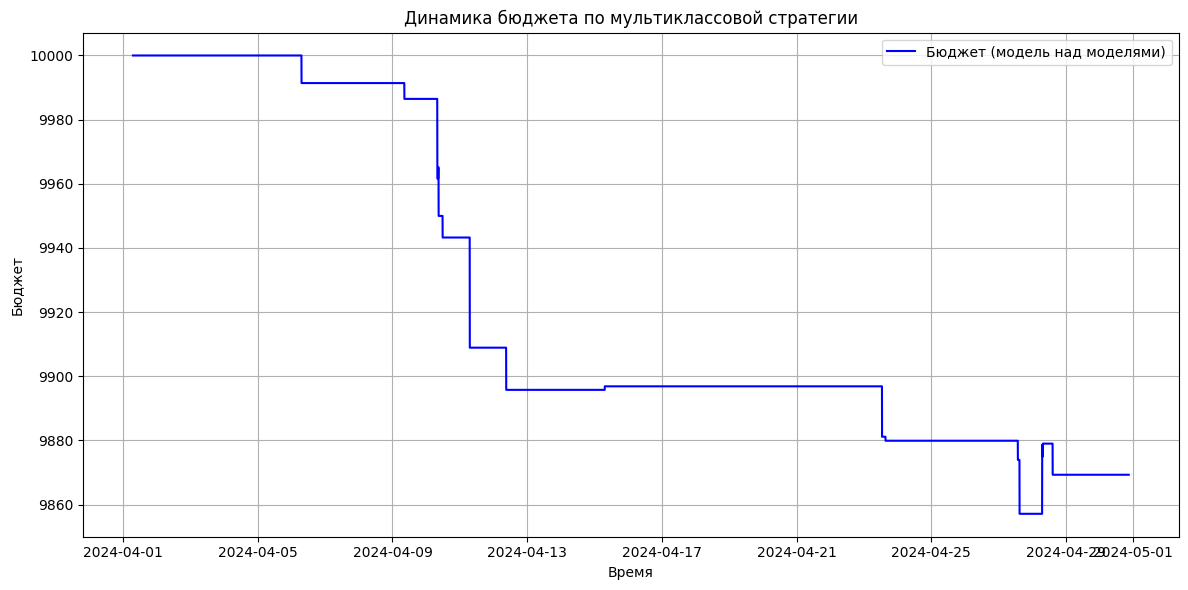

In [128]:

# df = pd.read_csv('predictions_multiclass.csv', parse_dates=['utc'])

df = final_df


# Параметры
initial_budget = 10000
commission_rate = 0.0004

budget = initial_budget
budget_history = [budget]
timestamps = [df['utc'].iloc[0]]

for i in range(len(df) - 1):
    row = df.iloc[i]
    next_row = df.iloc[i + 1]

    price_now = row['close']
    price_next = next_row['close']
    signal = row['predicted_class']

    if signal == 1:  # Long
        n_shares = int(budget // price_now)
        if n_shares == 0:
            pass
        else:
            buy_cost = n_shares * price_now * (1 + commission_rate)
            sell_revenue = n_shares * price_next * (1 - commission_rate)
            budget += sell_revenue - buy_cost

    elif signal == -1:  # Short
        n_shares = int(budget // price_now)
        if n_shares == 0:
            pass
        else:
            sell_proceeds = n_shares * price_now * (1 - commission_rate)
            buy_cost = n_shares * price_next * (1 + commission_rate)
            budget += sell_proceeds - buy_cost

    # Если signal == 0 — ничего не делаем
    budget_history.append(budget)
    timestamps.append(next_row['utc'])

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(timestamps, budget_history, label='Бюджет (модель над моделями)', color='blue')
plt.xlabel('Время')
plt.ylabel('Бюджет')
plt.title('Динамика бюджета по мультиклассовой стратегии')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


                  utc    open   close  predicted_proba_model1  \
0 2024-03-01 07:00:00  54.860  55.065                0.160582   
1 2024-03-01 07:01:00  55.095  55.000                0.162545   
2 2024-03-01 07:02:00  55.010  54.965                0.169827   
3 2024-03-01 07:03:00  54.955  55.000                0.145057   
4 2024-03-01 07:04:00  54.990  54.985                0.123355   

   predicted_proba_model2  close_t+1  target  
0                0.120569     55.000      -1  
1                0.253968     54.965      -1  
2                0.237509     55.000       1  
3                0.286789     54.985      -1  
4                0.476431     54.935      -1  


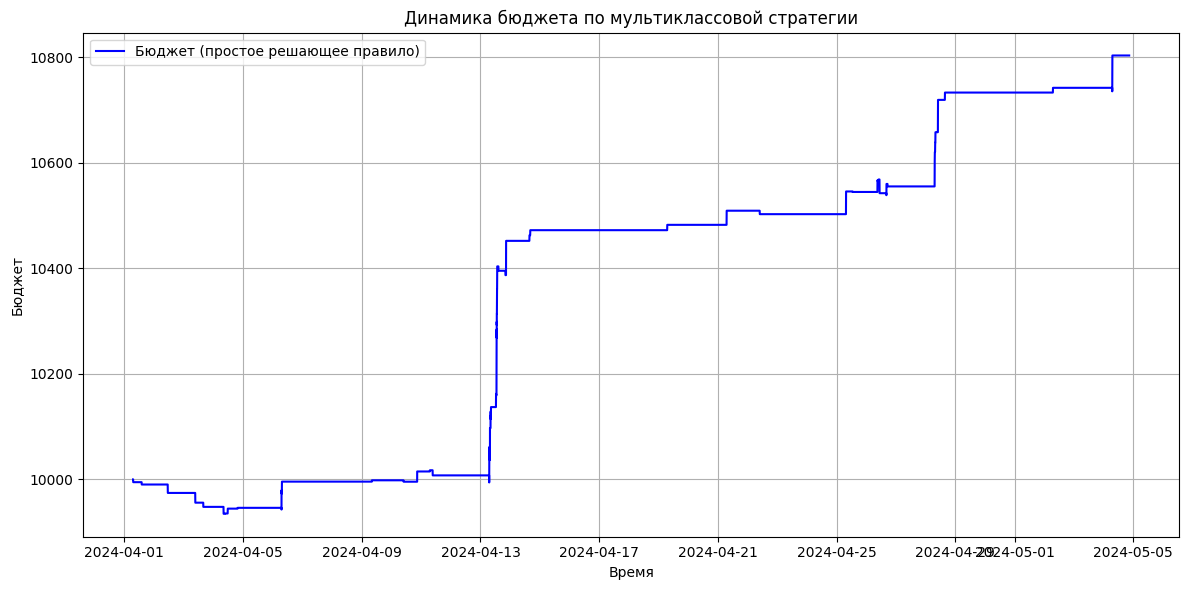

In [132]:

# df = pd.read_csv('predictions_multiclass.csv', parse_dates=['utc'])

import pandas as pd

# Загрузим два датафрейма
df1 = pd.read_csv("MMK.csv", parse_dates=["utc"])
df2 = pd.read_csv("MMK_short.csv", parse_dates=["utc"])

# Переименуем predicted_proba, чтобы они отличались
df1 = df1.rename(columns={"predicted_proba": "predicted_proba_model1"})
df2 = df2.rename(columns={"predicted_proba": "predicted_proba_model2"})

# Объединение по utc
merged = pd.merge(df1[['utc', 'open', 'close', 'predicted_proba_model1']],
                  df2[['utc', 'predicted_proba_model2']],
                  on='utc')

# Добавим колонку close_{t+1}
merged['close_t+1'] = merged['close'].shift(-1)

# Комиссия в две стороны (покупка + продажа)
commission = 0

# Условия для таргета
merged['target'] = 0
merged.loc[(merged['close_t+1'] / merged['close']) > (1 + commission), 'target'] = 1
merged.loc[(merged['close'] / merged['close_t+1']) > (1 + commission), 'target'] = -1

# Удалим последнюю строку с NaN в close_t+1
merged = merged.dropna(subset=['close_t+1'])

# Готово! Сохраняем или смотрим
print(merged.head())


df = merged

df = df[df.utc >= start_time]

df['predicted_class'] = df[['predicted_proba_model1', 'predicted_proba_model2']].apply(
    lambda row: 1 if row[0] > 0.5 else (-1 if row[1] > 0.5 else 0), axis=1)

# Параметры
initial_budget = 10000
commission_rate = 0.0004

budget = initial_budget
budget_history = [budget]
timestamps = [df['utc'].iloc[0]]

for i in range(len(df) - 1):
    row = df.iloc[i]
    next_row = df.iloc[i + 1]

    price_now = row['close']
    price_next = next_row['close']
    signal = row['predicted_class']

    if signal == 1:  # Long
        n_shares = int(budget // price_now)
        if n_shares == 0:
            pass
        else:
            buy_cost = n_shares * price_now * (1 + commission_rate)
            sell_revenue = n_shares * price_next * (1 - commission_rate)
            budget += sell_revenue - buy_cost

    elif signal == -1:  # Short
        n_shares = int(budget // price_now)
        if n_shares == 0:
            pass
        else:
            sell_proceeds = n_shares * price_now * (1 - commission_rate)
            buy_cost = n_shares * price_next * (1 + commission_rate)
            budget += sell_proceeds - buy_cost

    # Если signal == 0 — ничего не делаем
    budget_history.append(budget)
    timestamps.append(next_row['utc'])

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(timestamps, budget_history, label='Бюджет (простое решающее правило)', color='blue')
plt.xlabel('Время')
plt.ylabel('Бюджет')
plt.title('Динамика бюджета по мультиклассовой стратегии')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
